# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

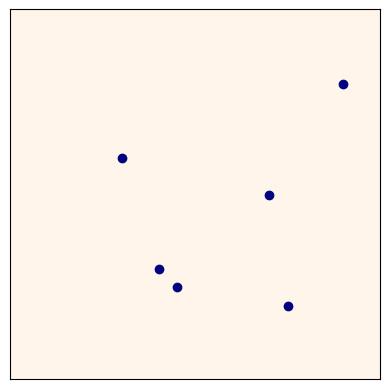

In [2]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

In [3]:
# 4 layers, mostly Linear+Leaking RELU. Last layer is sigmoid

class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

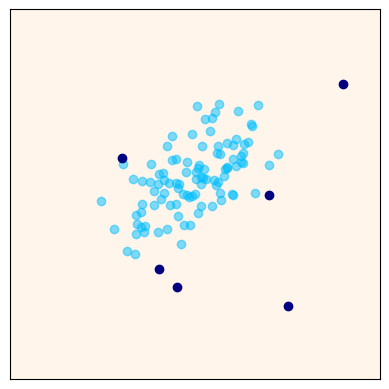

In [4]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z=torch.randn((b,n_in)).to(device)
x=G(z)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [5]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

tensor(-0.6583, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
[0/1000], 1.218330


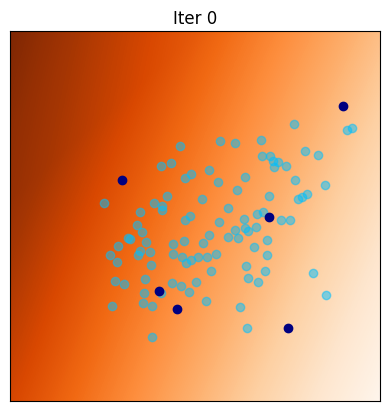

tensor(5.7900, device='cuda:0', grad_fn=<MeanBackward0>) tensor(5.7281, device='cuda:0', grad_fn=<MeanBackward0>)
[100/1000], -5.066253


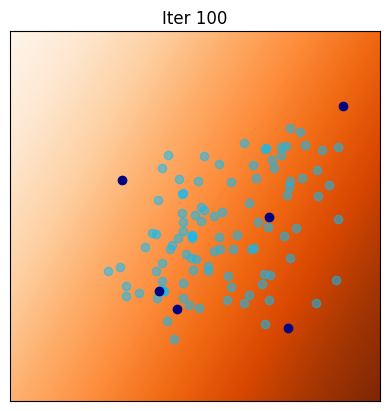

tensor(45.8072, device='cuda:0', grad_fn=<MeanBackward0>) tensor(44.8209, device='cuda:0', grad_fn=<MeanBackward0>)
[200/1000], -44.565205


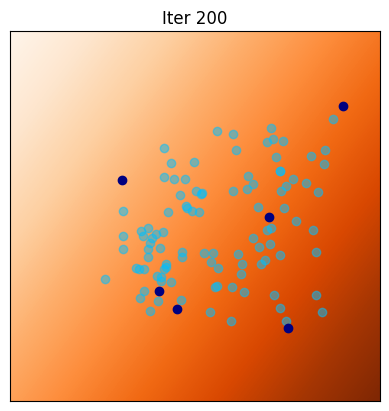

tensor(157.9970, device='cuda:0', grad_fn=<MeanBackward0>) tensor(153.5522, device='cuda:0', grad_fn=<MeanBackward0>)
[300/1000], -155.864349


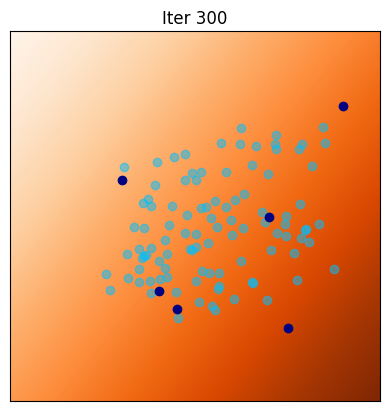

tensor(375.0244, device='cuda:0', grad_fn=<MeanBackward0>) tensor(367.4618, device='cuda:0', grad_fn=<MeanBackward0>)
[400/1000], -371.694244


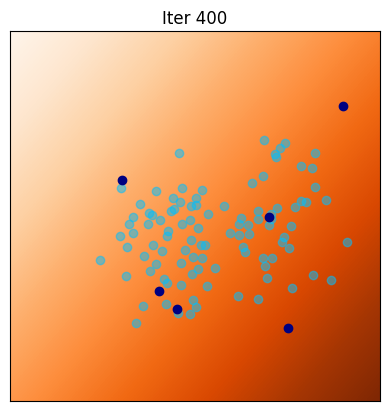

tensor(723.9591, device='cuda:0', grad_fn=<MeanBackward0>) tensor(697.7477, device='cuda:0', grad_fn=<MeanBackward0>)
[500/1000], -719.204285


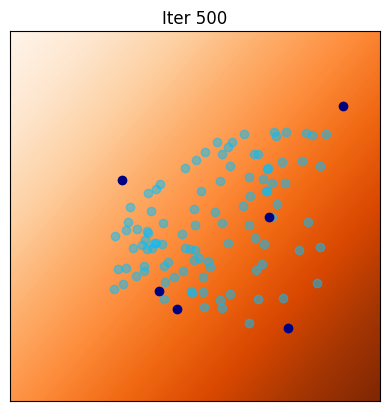

tensor(1228.8336, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1196.0903, device='cuda:0', grad_fn=<MeanBackward0>)
[600/1000], -1222.398193


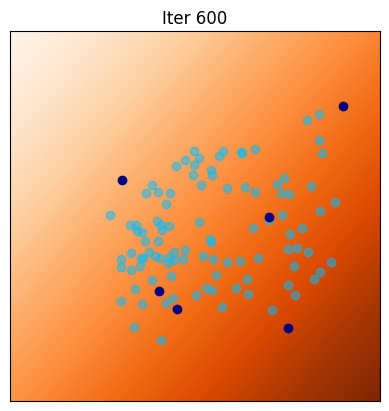

tensor(1911.1058, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1839.6643, device='cuda:0', grad_fn=<MeanBackward0>)
[700/1000], -1902.809448


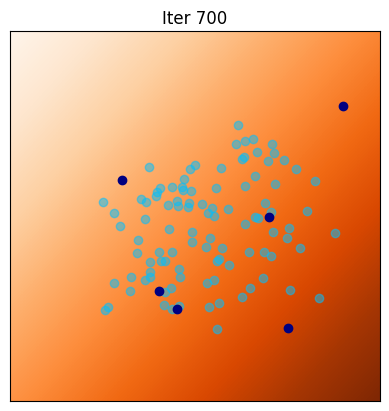

tensor(2789.9570, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2743.3213, device='cuda:0', grad_fn=<MeanBackward0>)
[800/1000], -2779.585938


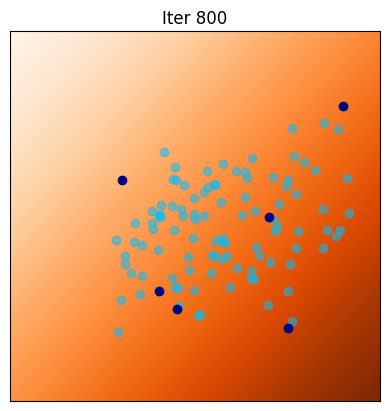

tensor(3882.5537, device='cuda:0', grad_fn=<MeanBackward0>) tensor(3745.8867, device='cuda:0', grad_fn=<MeanBackward0>)
[900/1000], -3869.984863


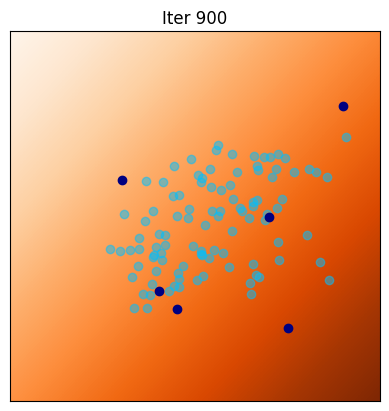

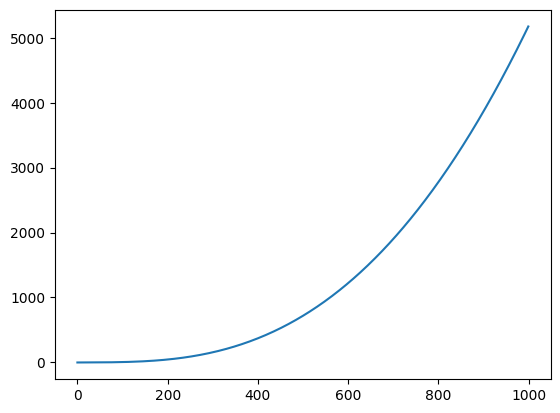

In [6]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    ### ... ###
    z=torch.randn((b,n_in)).to(device)
    x=G(z)
    Dloss = -(torch.mean(D(y)) - torch.mean(x))
    Dloss.backward()
    ### ... ###

    optimD.step()

    ### ... Weight Clipping ... ###
    for param in D.parameters() :
      param.data.clamp(-clip_value,clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print(torch.mean(D(y)), torch.mean(D(G(z))))
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [7]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [8]:
lipconstant(D,x,y).item()

3398.201904296875

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [9]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 10**-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

tensor(11540982., device='cuda:0', grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

[0/1000], Dloss=0.5676, Lip(D)=0.2673


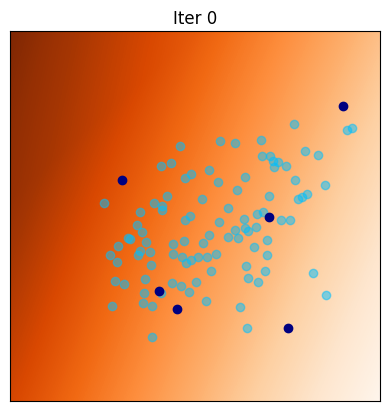

[100/1000], Dloss=0.0139, Lip(D)=0.9814


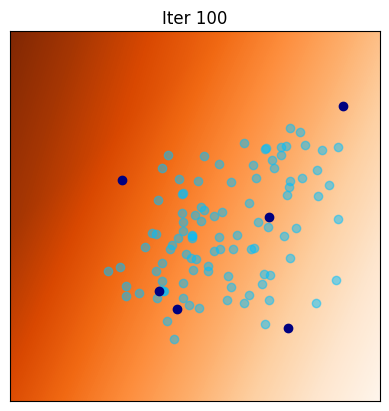

[200/1000], Dloss=0.0286, Lip(D)=0.9691


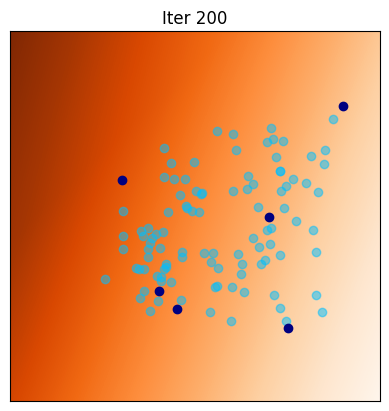

[300/1000], Dloss=0.0367, Lip(D)=0.9968


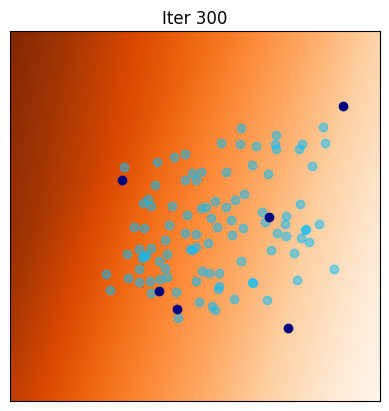

[400/1000], Dloss=0.0260, Lip(D)=0.9930


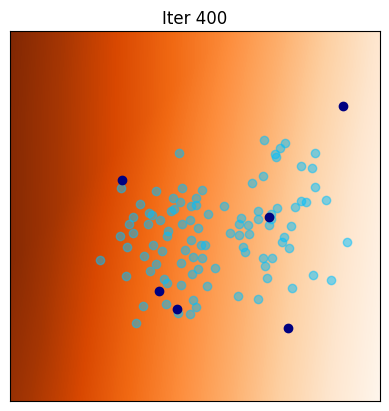

[500/1000], Dloss=0.0288, Lip(D)=0.9917


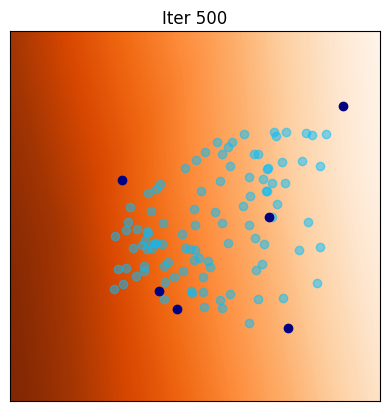

[600/1000], Dloss=0.0157, Lip(D)=1.0388


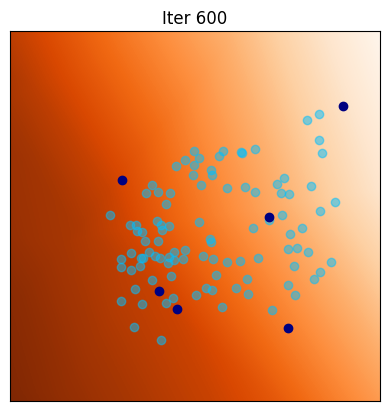

[700/1000], Dloss=0.0038, Lip(D)=1.0377


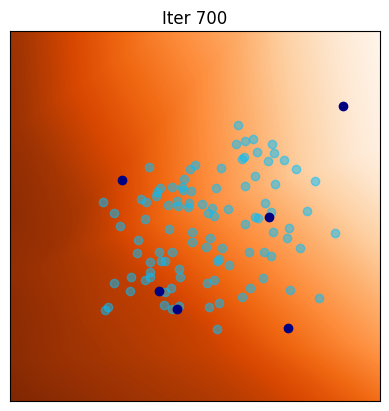

[800/1000], Dloss=-0.0722, Lip(D)=1.0433


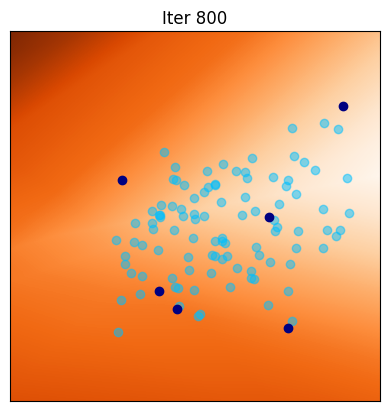

[900/1000], Dloss=-0.0836, Lip(D)=1.0710


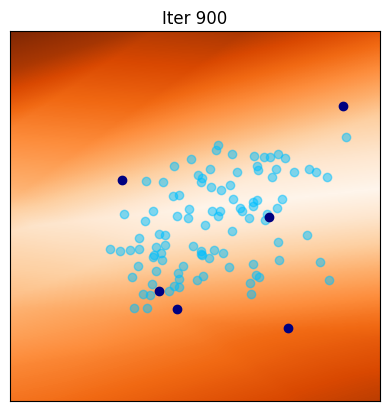

Final estimated Lipschitz constant =  0.9649325609207153


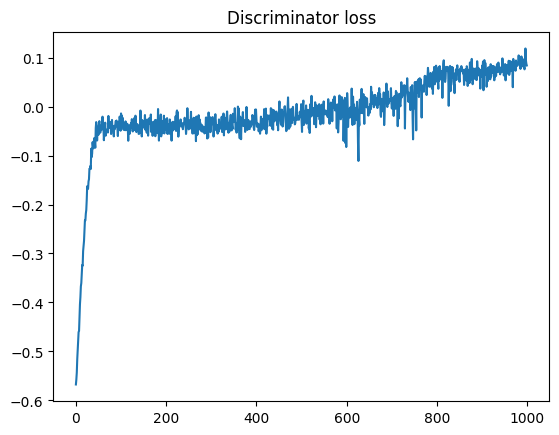

In [10]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000
gpw = 1  #0.028   #10 # parameter for gradient penalty

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):
    optimD.zero_grad()
    ### UPDATE OF D ###

    z=torch.randn((b,n_in)).to(device)
    x=G(z)
    Dloss = -(torch.mean(D(y)) - torch.mean(D(G(z)))- gpw*gradient_penalty(D,x,y))
    Dloss.backward()
    optimD.step()
    ### ... Weight Clipping ... ###
    for param in D.parameters() :
      param.data.clamp(-clip_value,clip_value)
    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst,lipconstant(D,x,y).item()))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[1/100] 	Loss_D: -0.1509	Loss_G: 0.0435	Lip(D)=1.5938
[2/100] 	Loss_D: -0.0906	Loss_G: 0.3119	Lip(D)=1.6077
[3/100] 	Loss_D: -0.1201	Loss_G: 0.2088	Lip(D)=1.7117
[4/100] 	Loss_D: -0.0732	Loss_G: -0.2248	Lip(D)=1.3617
[5/100] 	Loss_D: -0.1140	Loss_G: -0.2963	Lip(D)=1.4461


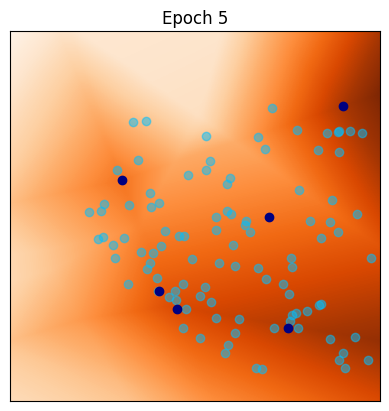

[6/100] 	Loss_D: -0.1349	Loss_G: 0.0408	Lip(D)=1.4409
[7/100] 	Loss_D: -0.0682	Loss_G: 0.1842	Lip(D)=1.5187
[8/100] 	Loss_D: -0.1265	Loss_G: 0.3726	Lip(D)=1.5967
[9/100] 	Loss_D: -0.0947	Loss_G: 0.2311	Lip(D)=1.2547
[10/100] 	Loss_D: -0.0637	Loss_G: 0.5788	Lip(D)=1.4005


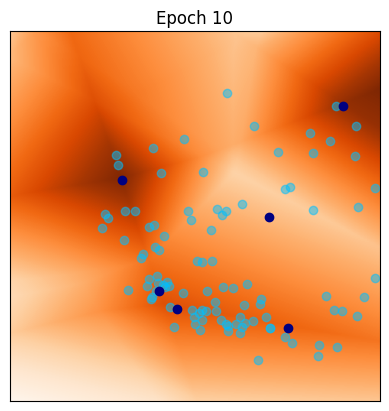

[11/100] 	Loss_D: -0.0984	Loss_G: 0.5153	Lip(D)=1.2516
[12/100] 	Loss_D: -0.0702	Loss_G: 0.1753	Lip(D)=1.0989
[13/100] 	Loss_D: -0.0793	Loss_G: 0.2446	Lip(D)=1.1908
[14/100] 	Loss_D: -0.0496	Loss_G: 0.3910	Lip(D)=1.4716
[15/100] 	Loss_D: -0.0789	Loss_G: -0.2589	Lip(D)=1.2352


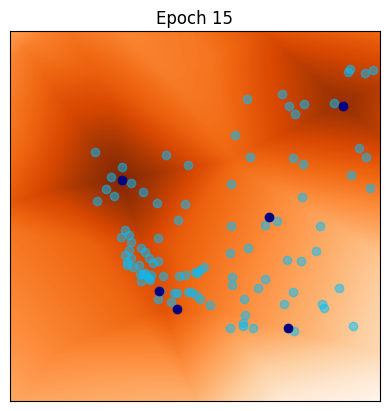

[16/100] 	Loss_D: -0.0848	Loss_G: -0.8863	Lip(D)=1.1957
[17/100] 	Loss_D: -0.0776	Loss_G: -0.8362	Lip(D)=1.2405
[18/100] 	Loss_D: -0.0554	Loss_G: 0.2061	Lip(D)=1.4387
[19/100] 	Loss_D: -0.0942	Loss_G: -0.4403	Lip(D)=1.5092
[20/100] 	Loss_D: -0.0102	Loss_G: -0.9415	Lip(D)=1.1207


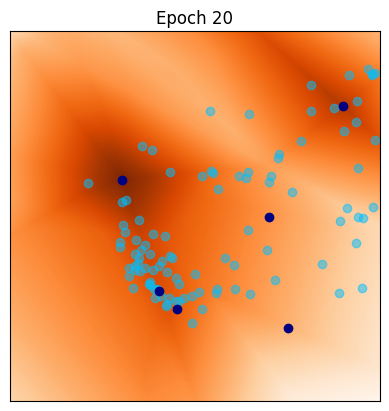

[21/100] 	Loss_D: -0.0810	Loss_G: -1.4601	Lip(D)=1.5141
[22/100] 	Loss_D: -0.1144	Loss_G: -1.9797	Lip(D)=1.3125
[23/100] 	Loss_D: -0.1210	Loss_G: -0.8274	Lip(D)=1.0272
[24/100] 	Loss_D: -0.0963	Loss_G: -0.4572	Lip(D)=1.5105
[25/100] 	Loss_D: -0.1339	Loss_G: -0.7134	Lip(D)=1.2456


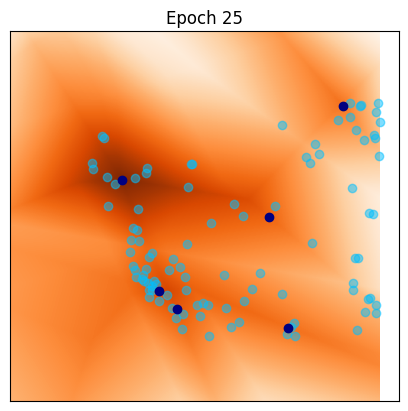

[26/100] 	Loss_D: -0.0952	Loss_G: -0.8682	Lip(D)=1.5261
[27/100] 	Loss_D: -0.1272	Loss_G: -0.9614	Lip(D)=1.3776
[28/100] 	Loss_D: -0.0991	Loss_G: -1.1527	Lip(D)=1.5067
[29/100] 	Loss_D: -0.0949	Loss_G: -2.0798	Lip(D)=1.3086
[30/100] 	Loss_D: -0.1299	Loss_G: -2.9540	Lip(D)=1.4272


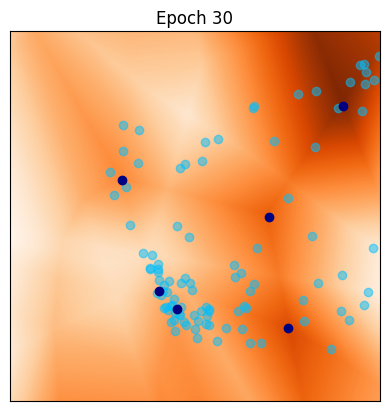

[31/100] 	Loss_D: -0.1203	Loss_G: -3.4792	Lip(D)=1.5086
[32/100] 	Loss_D: -0.1244	Loss_G: -3.4771	Lip(D)=1.5048
[33/100] 	Loss_D: -0.0790	Loss_G: -4.3392	Lip(D)=1.4542
[34/100] 	Loss_D: -0.0977	Loss_G: -5.4293	Lip(D)=1.5232
[35/100] 	Loss_D: -0.1102	Loss_G: -6.2318	Lip(D)=1.4701


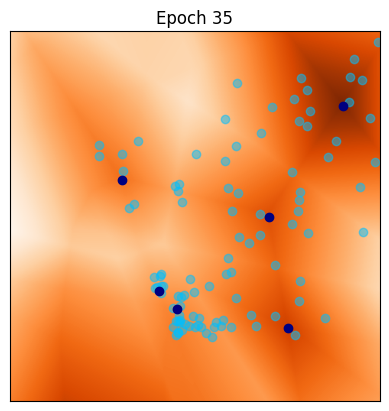

[36/100] 	Loss_D: -0.0956	Loss_G: -6.4878	Lip(D)=1.7495
[37/100] 	Loss_D: -0.0515	Loss_G: -6.5510	Lip(D)=1.4553
[38/100] 	Loss_D: -0.1291	Loss_G: -7.2409	Lip(D)=1.2846
[39/100] 	Loss_D: -0.1017	Loss_G: -7.7314	Lip(D)=1.3170
[40/100] 	Loss_D: -0.0806	Loss_G: -8.1170	Lip(D)=1.3531


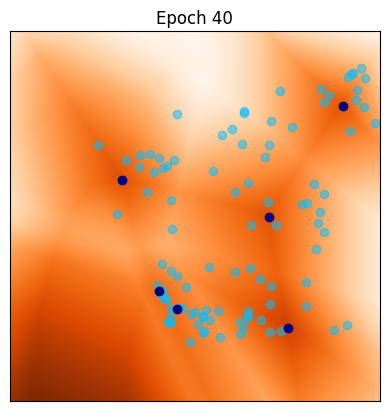

[41/100] 	Loss_D: -0.1041	Loss_G: -8.4190	Lip(D)=1.4880
[42/100] 	Loss_D: -0.1052	Loss_G: -8.6510	Lip(D)=1.2805
[43/100] 	Loss_D: -0.0904	Loss_G: -8.8865	Lip(D)=1.3082
[44/100] 	Loss_D: -0.0594	Loss_G: -9.5211	Lip(D)=1.3666
[45/100] 	Loss_D: -0.0930	Loss_G: -9.8025	Lip(D)=1.2630


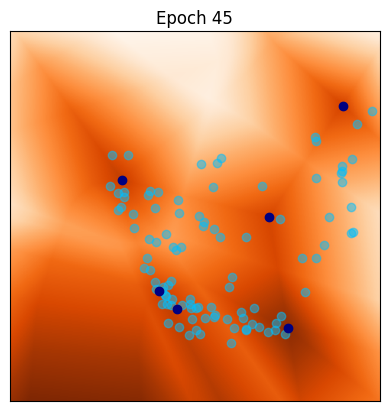

[46/100] 	Loss_D: -0.0765	Loss_G: -9.2585	Lip(D)=1.3716
[47/100] 	Loss_D: -0.1010	Loss_G: -9.4197	Lip(D)=1.2127
[48/100] 	Loss_D: -0.0836	Loss_G: -9.7122	Lip(D)=1.4495
[49/100] 	Loss_D: -0.0971	Loss_G: -10.6371	Lip(D)=1.2254
[50/100] 	Loss_D: -0.0699	Loss_G: -10.7887	Lip(D)=1.4956


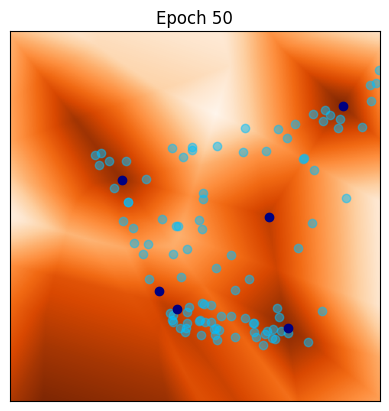

[51/100] 	Loss_D: -0.0765	Loss_G: -10.5972	Lip(D)=1.3211
[52/100] 	Loss_D: -0.0867	Loss_G: -10.5327	Lip(D)=1.1803
[53/100] 	Loss_D: -0.1027	Loss_G: -11.2385	Lip(D)=1.2261
[54/100] 	Loss_D: -0.0825	Loss_G: -11.8740	Lip(D)=1.4544
[55/100] 	Loss_D: -0.0784	Loss_G: -11.9832	Lip(D)=1.3259


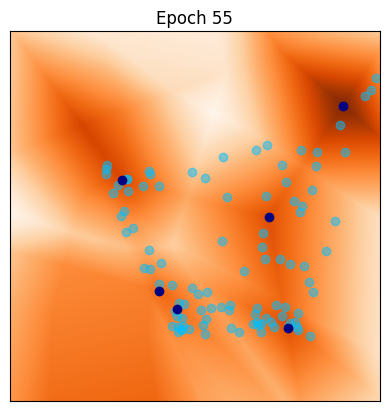

[56/100] 	Loss_D: -0.0882	Loss_G: -11.8653	Lip(D)=1.1845
[57/100] 	Loss_D: -0.0654	Loss_G: -12.4457	Lip(D)=1.0477
[58/100] 	Loss_D: -0.0843	Loss_G: -13.6486	Lip(D)=1.1401
[59/100] 	Loss_D: -0.0805	Loss_G: -14.4443	Lip(D)=1.1694
[60/100] 	Loss_D: -0.0678	Loss_G: -14.0290	Lip(D)=1.3594


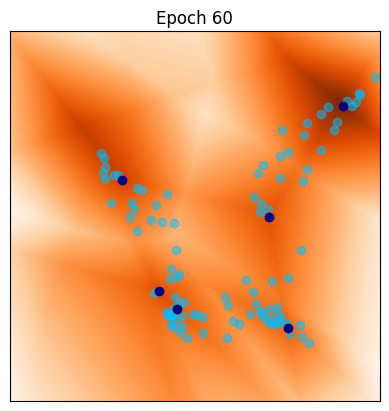

[61/100] 	Loss_D: -0.0379	Loss_G: -14.6068	Lip(D)=1.4211
[62/100] 	Loss_D: -0.0687	Loss_G: -14.8352	Lip(D)=1.0298
[63/100] 	Loss_D: -0.0789	Loss_G: -15.2561	Lip(D)=1.0562
[64/100] 	Loss_D: -0.0852	Loss_G: -15.5260	Lip(D)=1.1974
[65/100] 	Loss_D: -0.0742	Loss_G: -15.2589	Lip(D)=1.3992


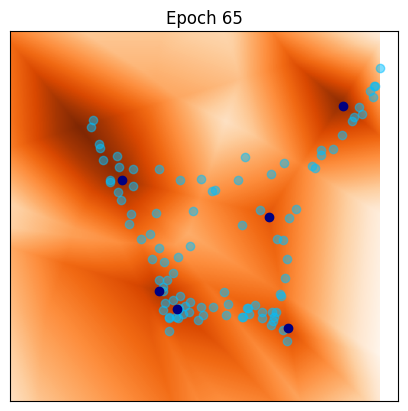

[66/100] 	Loss_D: -0.0761	Loss_G: -15.7613	Lip(D)=1.2014
[67/100] 	Loss_D: -0.0830	Loss_G: -17.0919	Lip(D)=1.1898
[68/100] 	Loss_D: -0.0807	Loss_G: -17.0309	Lip(D)=1.2754
[69/100] 	Loss_D: -0.0539	Loss_G: -18.0940	Lip(D)=1.8023
[70/100] 	Loss_D: -0.0598	Loss_G: -18.2398	Lip(D)=1.7273


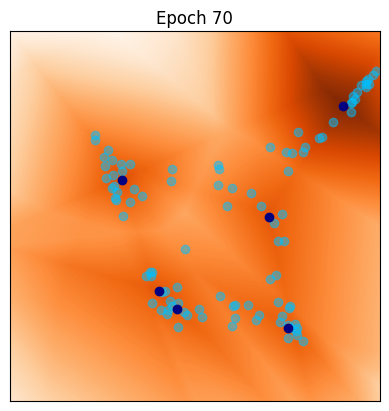

[71/100] 	Loss_D: -0.0803	Loss_G: -18.9781	Lip(D)=1.1974
[72/100] 	Loss_D: -0.0730	Loss_G: -19.4311	Lip(D)=1.1462
[73/100] 	Loss_D: -0.0727	Loss_G: -20.1096	Lip(D)=1.2780
[74/100] 	Loss_D: -0.0658	Loss_G: -20.9780	Lip(D)=1.0830
[75/100] 	Loss_D: -0.0847	Loss_G: -20.1153	Lip(D)=1.3583


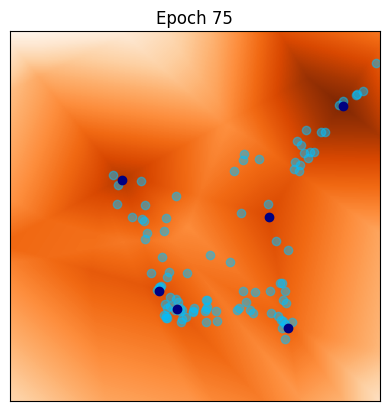

[76/100] 	Loss_D: -0.0322	Loss_G: -21.5721	Lip(D)=1.5246
[77/100] 	Loss_D: -0.0468	Loss_G: -21.8460	Lip(D)=1.0517
[78/100] 	Loss_D: -0.0643	Loss_G: -21.3728	Lip(D)=1.2248
[79/100] 	Loss_D: -0.0694	Loss_G: -21.3336	Lip(D)=1.2052
[80/100] 	Loss_D: -0.0458	Loss_G: -23.2212	Lip(D)=1.5369


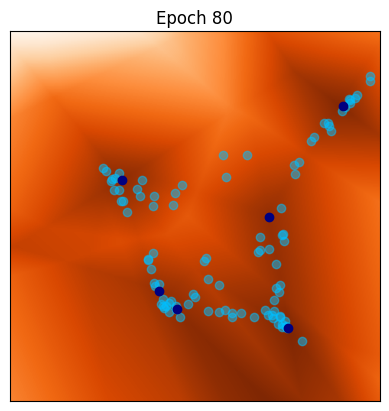

[81/100] 	Loss_D: -0.0720	Loss_G: -23.7560	Lip(D)=1.2132
[82/100] 	Loss_D: -0.0731	Loss_G: -22.7618	Lip(D)=1.0684
[83/100] 	Loss_D: -0.0622	Loss_G: -23.5767	Lip(D)=1.1602
[84/100] 	Loss_D: -0.0772	Loss_G: -23.9554	Lip(D)=1.2970
[85/100] 	Loss_D: -0.0739	Loss_G: -24.2702	Lip(D)=1.1856


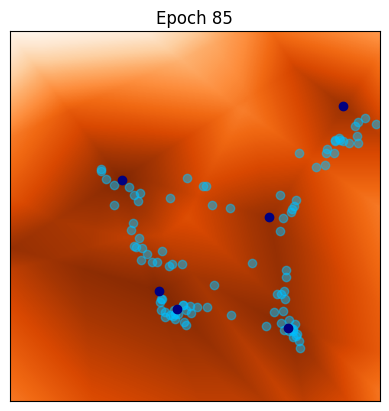

[86/100] 	Loss_D: -0.1053	Loss_G: -22.9843	Lip(D)=1.4119
[87/100] 	Loss_D: -0.0864	Loss_G: -24.4125	Lip(D)=1.2548
[88/100] 	Loss_D: -0.0914	Loss_G: -24.4950	Lip(D)=1.3657
[89/100] 	Loss_D: -0.0809	Loss_G: -26.7648	Lip(D)=1.3571
[90/100] 	Loss_D: -0.0687	Loss_G: -25.8579	Lip(D)=1.2164


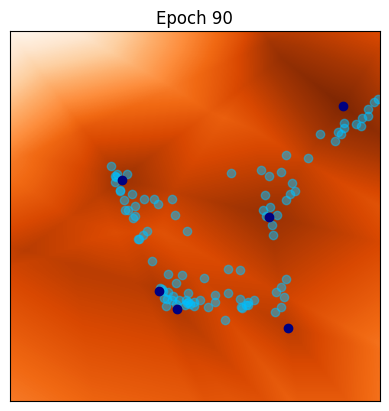

[91/100] 	Loss_D: -0.0798	Loss_G: -25.4533	Lip(D)=1.2598
[92/100] 	Loss_D: -0.0765	Loss_G: -26.0070	Lip(D)=0.9893
[93/100] 	Loss_D: -0.0722	Loss_G: -25.2173	Lip(D)=1.5885
[94/100] 	Loss_D: -0.0774	Loss_G: -26.7320	Lip(D)=1.3318
[95/100] 	Loss_D: -0.0975	Loss_G: -26.8451	Lip(D)=1.2714


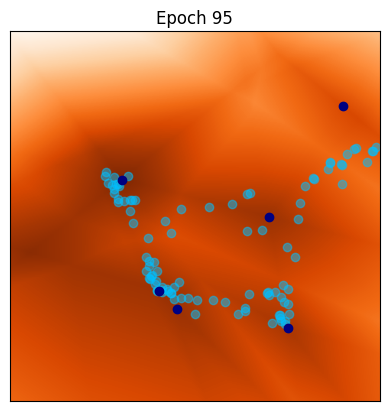

[96/100] 	Loss_D: -0.1240	Loss_G: -27.4673	Lip(D)=1.3735
[97/100] 	Loss_D: -0.0807	Loss_G: -27.7364	Lip(D)=1.3928
[98/100] 	Loss_D: -0.0782	Loss_G: -27.8546	Lip(D)=1.4221
[99/100] 	Loss_D: -0.1246	Loss_G: -30.3999	Lip(D)=1.3121


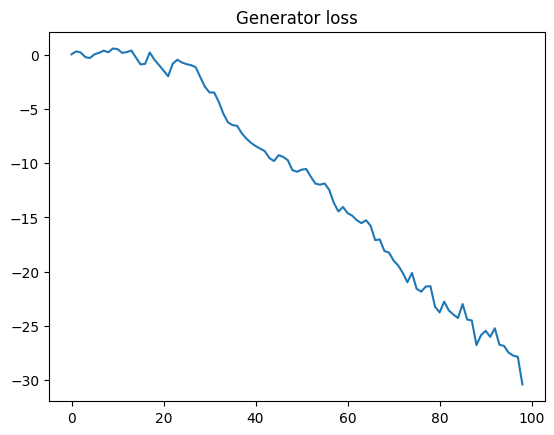

<All keys matched successfully>

In [11]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
      optimD.zero_grad()
    ### UPDATE OF D ###

      z=torch.randn((b,n_in)).to(device)
      x=G(z)
      Dloss = -(torch.mean(D(y)) - torch.mean(D(G(z)))- gpw*gradient_penalty(D,x,y))
      Dloss.backward()
      optimD.step()
      ### ... Weight Clipping ... ###
      for param in D.parameters() :
        param.data.clamp(-clip_value,clip_value)
    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
      optimG.zero_grad()
      z=torch.randn((b,n_in)).to(device)
      Gloss=- torch.mean(D(G(z)))
      Gloss.backward()
      optimG.step()
        ### ... ###

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())